In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_sign_selfeats = pd.read_csv(params.sign_featall_csv, index_col=0, parse_dates=True)[params.features_cols_tick + params.signals_cols_tick]
df_sign_selfeats = df_sign_selfeats[df_sign_selfeats.index.year >= params.init_df_year] ###########
df_sign_selfeats

,atr_pct_7,range_pct,atr_pct_28,ret_std_63,donch_w_20,ret_std_21,atr_pct_14,time_afthour,kc_w_20_20_1.5,bb_w_20_2p0,dist_low_200,time_in_sess,donch_w_55,trade_count,bb_w_50_2p0,lower_shad,time_premark,upper_shad,dist_high_200,time_hour,volume,time_minute,time_week_of_year,sma_pct_200,atr_7_RZ,time_month,atr_14_RZ,time_day_of_year,adx_28,vol_spike_28,sma_pct_50,atr_28_RZ,roc_5,body_pct,plus_di_14,roll_vwap_20_RZ,minus_di_7,plus_di_28,plus_di_7,rolling_max_close_200_RZ,minus_di_28,sma_pct_100,minus_di_14,roc_21,ret,rolling_min_close_200_RZ,rsi_21,ema_8_RZ,vol_spike_14,macd_signal_6_13_5_RZ,close_raw,targ_signal,signal_thresh
2019-01-02 08:00:00,1.000000,1.000000,0.539469,1.000000,1.000000,1.000000,0.964481,0.0,0.695324,1.000000,0.202308,0.0,1.000000,0.008669,0.559765,1.000000,1.0,0.0000,0.831573,0.270833,0.010662,0.270833,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.189077,0.824080,0.000000,1.000000,0.000000,0.000000,0.022780,0.000000,1.000000,0.000000,0.032218,0.624997,1.000000,0.000000,1.000000,0.000000,0.000000,0.366896,0.000000,0.000000,0.817293,0.000000,38.500,0.100676,0.121416
2019-01-02 08:01:00,1.000000,0.000000,0.519885,1.000000,1.000000,1.000000,0.895243,0.0,0.661687,1.000000,0.202308,0.0,1.000000,0.000255,0.787723,0.000000,1.0,0.0000,0.831573,0.270833,0.000161,0.271528,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.231728,0.029487,0.000000,1.000000,0.000000,0.502374,0.022780,0.000000,1.000000,0.000000,0.032218,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366897,0.000000,0.000000,0.030440,0.000000,38.500,0.121157,0.121416
2019-01-02 08:02:00,1.000000,0.009418,0.501454,1.000000,1.000000,1.000000,0.831810,0.0,0.630139,1.000000,0.202308,0.0,1.000000,0.000255,0.957824,0.000000,1.0,0.0000,0.831573,0.270833,0.000324,0.272222,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.272747,0.042049,0.000000,1.000000,0.000000,0.492905,0.023995,0.000000,0.999010,0.000000,0.033467,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366897,0.000000,0.000000,0.046070,0.000000,38.500,0.145805,0.121416
2019-01-02 08:03:00,1.000000,0.018836,0.484137,1.000000,1.000000,1.000000,0.773768,0.0,0.600605,1.000000,0.202308,0.0,1.000000,0.000255,1.000000,0.000000,1.0,0.0000,0.831573,0.270833,0.000486,0.272917,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.312189,0.054676,0.000000,1.000000,0.000000,0.483437,0.025240,0.000000,0.996104,0.000000,0.034866,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366898,0.000000,0.000000,0.060949,0.000000,38.500,0.175468,0.121416
2019-01-02 08:04:00,0.954582,0.000000,0.466529,1.000000,1.000000,1.000000,0.718153,0.0,0.571183,1.000000,0.202308,0.0,1.000000,0.000255,1.000000,0.000000,1.0,0.0000,0.831573,0.270833,0.001467,0.273611,0.500000,0.000000,1.000000,0.5,1.000000,0.502740,0.350222,0.128669,0.000000,1.000000,0.000000,0.502374,0.025240,0.000000,0.996104,0.000000,0.034866,0.624997,1.000000,0.000000,1.000000,0.000000,0.500539,0.366898,0.000000,0.000000,0.141225,0.000000,38.500,0.211165,0.121416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09 17:29:00,0.190067,0.134332,0.202690,0.172218,0.213304,0.173700,0.190330,0.0,0.195248,0.203577,0.285845,1.0,0.121831,0.281999,0.114646,0.207692,0.0,0.2400,0.004729,0.645833,0.054167,0.665972,0.519231,0.641047,0.145232,0.5,0.140438,0.521918,0.113547,0.247562,0.620479,0.150573,0.731854,0.573301,0.407921,0.440373,0.032127,0.360762,0.495497,0.602940,0.171854,0.622654,0.109079,0.666362,0.577876,1.000000,0.681735,0.476832,0.318022,0.543059,259.120,0.000000,0.065794
2026-01-09 17:30:00,0.195380,0.190326,0.204350,0.171744,0.234976,0.170860,0.193785,0.0,0.197654,0.222271,0.282234,1.0,0.133665,0.316930,0.118855,0.153846,0.0,0.8800,0.017737,0.645833,0.051326,0.666667,0.519231,0.636175,0.155111,0.5,0.149870,0.521918,0.125810,0.237045,0.610877,0.154733,0.731881,0.457354,0.426817,0

In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df              = df_sign_selfeats,
    train_batch     = params.hparams["TRAIN_BATCH"],
    train_workers   = params.hparams["TRAIN_WORKERS"],
    prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"],
    look_back       = params.hparams["LOOK_BACK"],
    features_cols   = params.features_cols_tick,
)

# del df_sign_selfeats, end_times_tr, end_times_val, end_times_te
# gc.collect()

for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


Preparing days:   0%|          | 0/1766 [00:00<?, ?it/s]

N_total: 1560011 look_back: 60 F: 50
Estimated X_buf size: 18.72 GB — using RAM (in-memory) (thresh 56 GiB)


Writing days:   0%|          | 0/1766 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

--- TRAIN ---
 calendar days : 1248  (2019-01-02 → 2023-12-14)
 windows       : 1094984  (per-day min=700, max=901, mean=877.4)
 window shape  : look_back=60, n_features=50
 dataloader    : batches= 78, batch_size=16, workers=8, pin_memory=True


mean_baseline train:   0%|          | 0/78 [00:04<?, ?it/s]

 baselines     : baseline prediction=0.129554, baseline RMSE = 0.232005

--- VAL ---
 calendar days : 254  (2023-12-15 → 2024-12-18)
 windows       : 228366  (per-day min=721, max=901, mean=899.1)
 window shape  : look_back=60, n_features=50
 dataloader    : batches=254, batch_size=1, workers=0, pin_memory=True


mean_baseline val:   0%|          | 0/254 [00:00<?, ?it/s]

 baselines     : baseline prediction=0.106076, baseline RMSE = 0.18606

--- TEST ---
 calendar days : 264  (2024-12-19 → 2026-01-09)
 windows       : 236661  (per-day min=515, max=901, mean=896.4)
 window shape  : look_back=60, n_features=50
 dataloader    : batches=264, batch_size=1, workers=0, pin_memory=True


mean_baseline test:   0%|          | 0/264 [00:00<?, ?it/s]

 baselines     : baseline prediction=0.128943, baseline RMSE = 0.252248



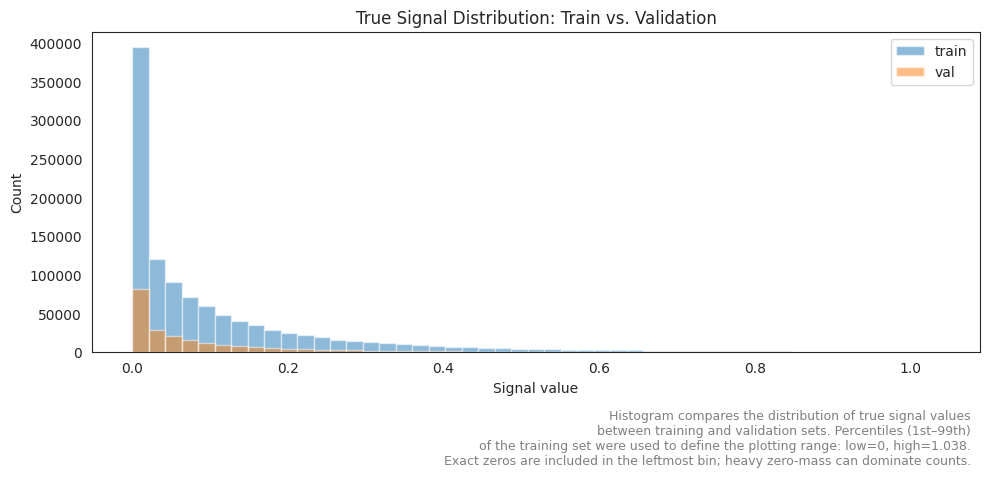

In [5]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

low, high = np.percentile(y_train, [1, 99])
bins = np.linspace(low, high, 50)   # zeros will be included in the leftmost bin if <= low

plt.figure(figsize=(10,5))
plt.hist(y_train, bins=bins, alpha=0.5, label="train")
plt.hist(y_val,   bins=bins, alpha=0.5, label="val")

# description / annotation
desc = (
    "Histogram compares the distribution of true signal values\n"
    "between training and validation sets. Percentiles (1st–99th)\n"
    f"of the training set were used to define the plotting range: low={low:.4g}, high={high:.4g}.\n"
    "Exact zeros are included in the leftmost bin; heavy zero-mass can dominate counts."
)
plt.title("True Signal Distribution: Train vs. Validation")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.legend()
plt.gca().text(
    0.99, -0.18, desc, ha="right", va="top", transform=plt.gca().transAxes,
    fontsize=9, color="gray"
)
plt.tight_layout()
plt.show()



In [6]:
# importlib.reload(models_custom) #############
# importlib.reload(params) #############

model = models_custom.ModelClass(
    n_feats             = len(params.features_cols_tick),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = params.features_cols_tick # for logging
model.to(params.device)  
print('Using:', params.device)
model

Using: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (input_proj): Linear(in_features=50, out_features=50, bias=True)
  (feature_proj): Linear(in_features=50, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.03, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.03, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.03, inplace=False)
     

In [7]:
base_lr = params.hparams["ONECYCLE_MAX_LR"]
head_lr = base_lr * params.hparams["HEAD_LR_PCT"] # if we want to reduce the learning rate applied to the head

params_map = dict(model.named_parameters())
head_param = params_map["head_flat.2.bias"] # select the correct head name for the lr reduction
backbone_params = [p for n,p in params_map.items() if n != "head_flat.2.bias"]

optimizer = AdamW(
    [
        {"params": backbone_params, "lr": base_lr},
        {"params": [head_param],    "lr": head_lr},
    ],
    weight_decay = params.hparams["WEIGHT_DECAY"]
)


batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 1.9999999999999998e-05
    max_lr: 0.0002
    max_momentum: 0.95
    maximize: False
    min_lr: 2.0000000000000002e-07
    weight_decay: 2e-06

Parameter Group 1
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 2e-05
    lr: 1.9999999999999998e-05
    max_lr: 0.0002
    max_momentum: 0.95
    maximize: False
    min_lr: 2.0000000000000002e-07
    weight_decay: 2e-06
)

Training sees 1248 unique trading days per epoch.

Model parameters: total=112,537, trainable=112,537

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 1, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 64, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 64, 'DROPOUT_SHORT': 0.1, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 64, 'TRANSFORMER_LAYERS': 2, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.03, 'USE_LONG_LSTM': False, 'LONG_UNITS': 64, 'DROPOUT_LONG': 0.1, 'FLATTEN_MODE': 'attn', 'PRED_HIDDEN': 96, 'ALPHA_SMOOTH': 0, 'WARMUP_STEPS': 3, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 2e-06, 'CLIPNORM': 2, 'ONECYCLE_MAX_LR': 0.0002, 'HEAD_LR_PCT': 1, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS'

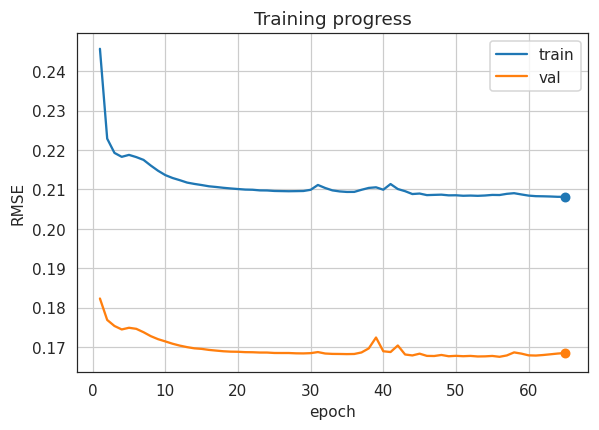

Epoch 1 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

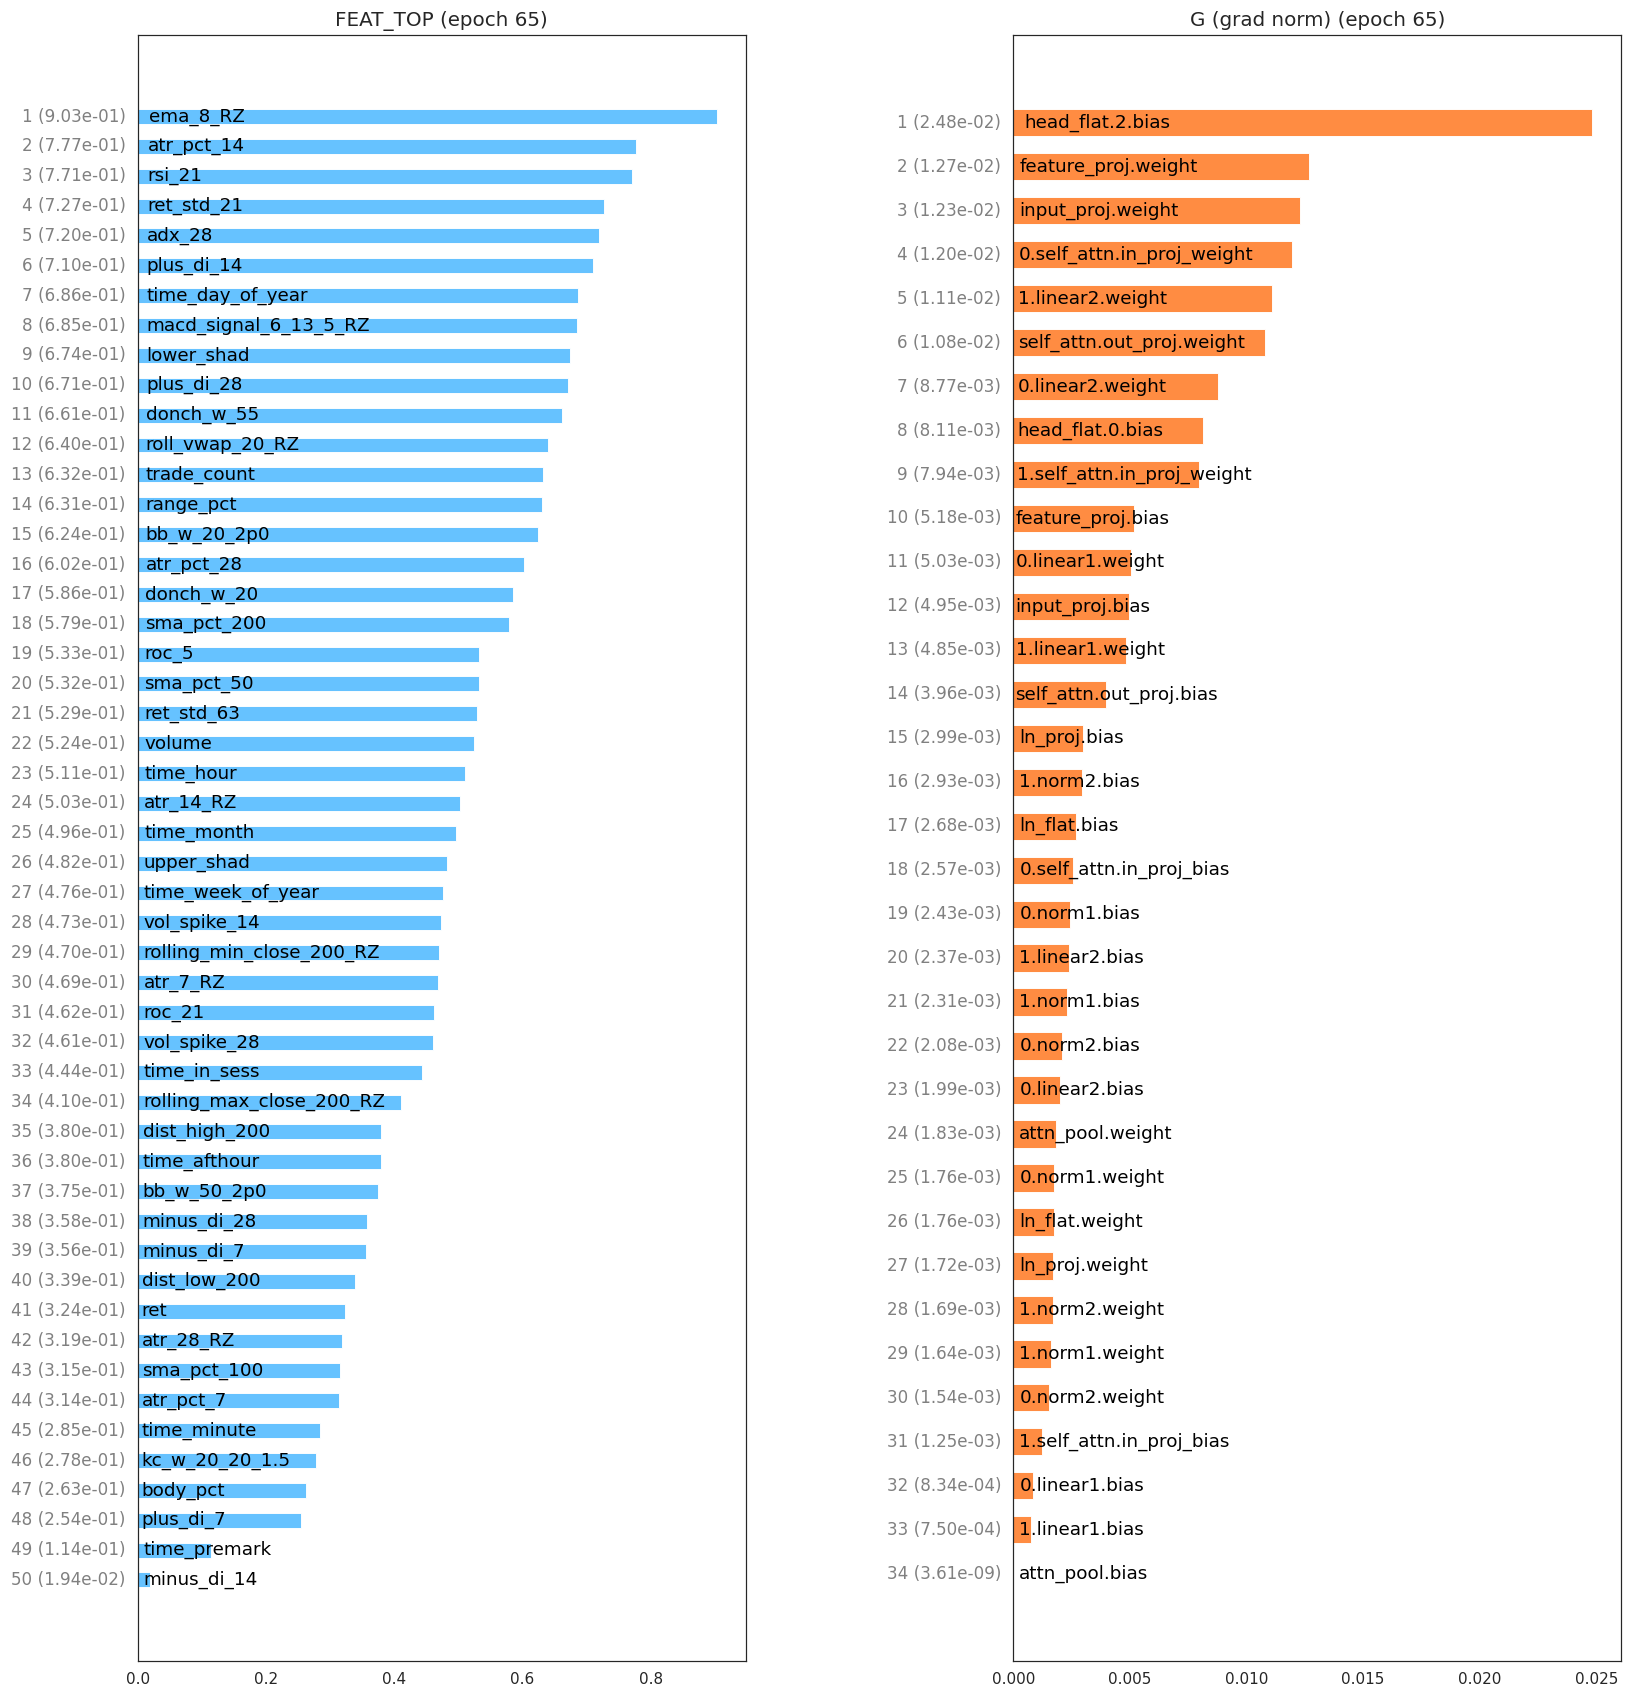

🔖 Saved folder-best checkpoint (_chp): AAPL_0.18230_chp.pth
Epoch 01  TRAIN→ RMSE=0.24570, R²=-0.101 |  VALID→ RMSE=0.18230, R²=0.040 |  lr=2.54e-05 |  loss=6.04665e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/78 [00:02<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17685_chp.pth
Epoch 02  TRAIN→ RMSE=0.22288, R²=0.094 |  VALID→ RMSE=0.17685, R²=0.097 |  lr=4.11e-05 |  loss=4.96864e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17532_chp.pth
Epoch 03  TRAIN→ RMSE=0.21927, R²=0.123 |  VALID→ RMSE=0.17532, R²=0.112 |  lr=6.51e-05 |  loss=4.80860e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17444_chp.pth
Epoch 04  TRAIN→ RMSE=0.21827, R²=0.131 |  VALID→ RMSE=0.17444, R²=0.121 |  lr=9.45e-05 |  loss=4.76494e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.21876, R²=0.127 |  VALID→ RMSE=0.17487, R²=0.117 |  lr=1.26e-04 |  loss=4.78655e-02 |  improved=False


Epoch 6 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.21820, R²=0.131 |  VALID→ RMSE=0.17460, R²=0.119 |  lr=1.55e-04 |  loss=4.76210e-02 |  improved=False


Epoch 7 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17374_chp.pth
Epoch 07  TRAIN→ RMSE=0.21749, R²=0.137 |  VALID→ RMSE=0.17374, R²=0.128 |  lr=1.79e-04 |  loss=4.73121e-02 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17274_chp.pth
Epoch 08  TRAIN→ RMSE=0.21605, R²=0.148 |  VALID→ RMSE=0.17274, R²=0.138 |  lr=1.95e-04 |  loss=4.66880e-02 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17197_chp.pth
Epoch 09  TRAIN→ RMSE=0.21473, R²=0.159 |  VALID→ RMSE=0.17197, R²=0.146 |  lr=2.00e-04 |  loss=4.61193e-02 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17140_chp.pth
Epoch 10  TRAIN→ RMSE=0.21363, R²=0.167 |  VALID→ RMSE=0.17140, R²=0.151 |  lr=2.00e-04 |  loss=4.56455e-02 |  improved=True


Epoch 11 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17081_chp.pth
Epoch 11  TRAIN→ RMSE=0.21289, R²=0.173 |  VALID→ RMSE=0.17081, R²=0.157 |  lr=2.00e-04 |  loss=4.53322e-02 |  improved=True


Epoch 12 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.17033_chp.pth
Epoch 12  TRAIN→ RMSE=0.21234, R²=0.177 |  VALID→ RMSE=0.17033, R²=0.162 |  lr=1.99e-04 |  loss=4.50946e-02 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16995_chp.pth
Epoch 13  TRAIN→ RMSE=0.21173, R²=0.182 |  VALID→ RMSE=0.16995, R²=0.166 |  lr=1.99e-04 |  loss=4.48379e-02 |  improved=True


Epoch 14 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16965_chp.pth
Epoch 14  TRAIN→ RMSE=0.21139, R²=0.185 |  VALID→ RMSE=0.16965, R²=0.169 |  lr=1.98e-04 |  loss=4.46940e-02 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16950_chp.pth
Epoch 15  TRAIN→ RMSE=0.21111, R²=0.187 |  VALID→ RMSE=0.16950, R²=0.170 |  lr=1.97e-04 |  loss=4.45737e-02 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16925_chp.pth
Epoch 16  TRAIN→ RMSE=0.21079, R²=0.189 |  VALID→ RMSE=0.16925, R²=0.173 |  lr=1.96e-04 |  loss=4.44399e-02 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16907_chp.pth
Epoch 17  TRAIN→ RMSE=0.21061, R²=0.191 |  VALID→ RMSE=0.16907, R²=0.174 |  lr=1.95e-04 |  loss=4.43643e-02 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16890_chp.pth
Epoch 18  TRAIN→ RMSE=0.21040, R²=0.192 |  VALID→ RMSE=0.16890, R²=0.176 |  lr=1.94e-04 |  loss=4.42776e-02 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16880_chp.pth
Epoch 19  TRAIN→ RMSE=0.21024, R²=0.194 |  VALID→ RMSE=0.16880, R²=0.177 |  lr=1.93e-04 |  loss=4.42072e-02 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16877_chp.pth
Epoch 20  TRAIN→ RMSE=0.21009, R²=0.195 |  VALID→ RMSE=0.16877, R²=0.177 |  lr=1.91e-04 |  loss=4.41464e-02 |  improved=True


Epoch 21 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16868_chp.pth
Epoch 21  TRAIN→ RMSE=0.20996, R²=0.196 |  VALID→ RMSE=0.16868, R²=0.178 |  lr=1.89e-04 |  loss=4.40889e-02 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16865_chp.pth
Epoch 22  TRAIN→ RMSE=0.20991, R²=0.196 |  VALID→ RMSE=0.16865, R²=0.178 |  lr=1.88e-04 |  loss=4.40712e-02 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16858_chp.pth
Epoch 23  TRAIN→ RMSE=0.20975, R²=0.197 |  VALID→ RMSE=0.16858, R²=0.179 |  lr=1.86e-04 |  loss=4.40034e-02 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16857_chp.pth
Epoch 24  TRAIN→ RMSE=0.20973, R²=0.198 |  VALID→ RMSE=0.16857, R²=0.179 |  lr=1.84e-04 |  loss=4.39936e-02 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16847_chp.pth
Epoch 25  TRAIN→ RMSE=0.20961, R²=0.198 |  VALID→ RMSE=0.16847, R²=0.180 |  lr=1.81e-04 |  loss=4.39423e-02 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16846_chp.pth
Epoch 26  TRAIN→ RMSE=0.20957, R²=0.199 |  VALID→ RMSE=0.16846, R²=0.180 |  lr=1.79e-04 |  loss=4.39265e-02 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16846_chp.pth
Epoch 27  TRAIN→ RMSE=0.20953, R²=0.199 |  VALID→ RMSE=0.16846, R²=0.180 |  lr=1.77e-04 |  loss=4.39125e-02 |  improved=True


Epoch 28 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16838_chp.pth
Epoch 28  TRAIN→ RMSE=0.20956, R²=0.199 |  VALID→ RMSE=0.16838, R²=0.181 |  lr=1.74e-04 |  loss=4.39230e-02 |  improved=True


Epoch 29 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16836_chp.pth
Epoch 29  TRAIN→ RMSE=0.20959, R²=0.199 |  VALID→ RMSE=0.16836, R²=0.181 |  lr=1.71e-04 |  loss=4.39374e-02 |  improved=True


Epoch 30 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.20989, R²=0.196 |  VALID→ RMSE=0.16842, R²=0.181 |  lr=1.69e-04 |  loss=4.40633e-02 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.21113, R²=0.187 |  VALID→ RMSE=0.16870, R²=0.178 |  lr=1.66e-04 |  loss=4.45819e-02 |  improved=False


Epoch 32 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16833_chp.pth
Epoch 32  TRAIN→ RMSE=0.21036, R²=0.193 |  VALID→ RMSE=0.16833, R²=0.181 |  lr=1.63e-04 |  loss=4.42591e-02 |  improved=True


Epoch 33 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16823_chp.pth
Epoch 33  TRAIN→ RMSE=0.20975, R²=0.197 |  VALID→ RMSE=0.16823, R²=0.182 |  lr=1.60e-04 |  loss=4.40032e-02 |  improved=True


Epoch 34 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16822_chp.pth
Epoch 34  TRAIN→ RMSE=0.20948, R²=0.199 |  VALID→ RMSE=0.16822, R²=0.183 |  lr=1.57e-04 |  loss=4.38913e-02 |  improved=True


Epoch 35 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16818_chp.pth
Epoch 35  TRAIN→ RMSE=0.20935, R²=0.200 |  VALID→ RMSE=0.16818, R²=0.183 |  lr=1.53e-04 |  loss=4.38366e-02 |  improved=True


Epoch 36 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.20937, R²=0.200 |  VALID→ RMSE=0.16821, R²=0.183 |  lr=1.50e-04 |  loss=4.38415e-02 |  improved=False


Epoch 37 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.20990, R²=0.196 |  VALID→ RMSE=0.16860, R²=0.179 |  lr=1.47e-04 |  loss=4.40652e-02 |  improved=False


Epoch 38 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 38  TRAIN→ RMSE=0.21038, R²=0.193 |  VALID→ RMSE=0.16963, R²=0.169 |  lr=1.43e-04 |  loss=4.42651e-02 |  improved=False


Epoch 39 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 39  TRAIN→ RMSE=0.21053, R²=0.191 |  VALID→ RMSE=0.17239, R²=0.142 |  lr=1.40e-04 |  loss=4.43291e-02 |  improved=False


Epoch 40 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 40  TRAIN→ RMSE=0.20992, R²=0.196 |  VALID→ RMSE=0.16890, R²=0.176 |  lr=1.36e-04 |  loss=4.40742e-02 |  improved=False


Epoch 41 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 41  TRAIN→ RMSE=0.21136, R²=0.185 |  VALID→ RMSE=0.16871, R²=0.178 |  lr=1.32e-04 |  loss=4.46817e-02 |  improved=False


Epoch 42 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 42  TRAIN→ RMSE=0.21009, R²=0.195 |  VALID→ RMSE=0.17037, R²=0.162 |  lr=1.29e-04 |  loss=4.41455e-02 |  improved=False


Epoch 43 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16808_chp.pth
Epoch 43  TRAIN→ RMSE=0.20955, R²=0.199 |  VALID→ RMSE=0.16808, R²=0.184 |  lr=1.25e-04 |  loss=4.39177e-02 |  improved=True


Epoch 44 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16784_chp.pth
Epoch 44  TRAIN→ RMSE=0.20882, R²=0.204 |  VALID→ RMSE=0.16784, R²=0.186 |  lr=1.21e-04 |  loss=4.36142e-02 |  improved=True


Epoch 45 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 45  TRAIN→ RMSE=0.20895, R²=0.203 |  VALID→ RMSE=0.16829, R²=0.182 |  lr=1.17e-04 |  loss=4.36668e-02 |  improved=False


Epoch 46 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16773_chp.pth
Epoch 46  TRAIN→ RMSE=0.20855, R²=0.207 |  VALID→ RMSE=0.16773, R²=0.187 |  lr=1.14e-04 |  loss=4.34997e-02 |  improved=True


Epoch 47 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16770_chp.pth
Epoch 47  TRAIN→ RMSE=0.20861, R²=0.206 |  VALID→ RMSE=0.16770, R²=0.188 |  lr=1.10e-04 |  loss=4.35254e-02 |  improved=True


Epoch 48 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 48  TRAIN→ RMSE=0.20867, R²=0.206 |  VALID→ RMSE=0.16796, R²=0.185 |  lr=1.06e-04 |  loss=4.35485e-02 |  improved=False


Epoch 49 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16764_chp.pth
Epoch 49  TRAIN→ RMSE=0.20849, R²=0.207 |  VALID→ RMSE=0.16764, R²=0.188 |  lr=1.02e-04 |  loss=4.34752e-02 |  improved=True


Epoch 50 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 50  TRAIN→ RMSE=0.20851, R²=0.207 |  VALID→ RMSE=0.16774, R²=0.187 |  lr=9.81e-05 |  loss=4.34837e-02 |  improved=False


Epoch 51 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 51  TRAIN→ RMSE=0.20838, R²=0.208 |  VALID→ RMSE=0.16765, R²=0.188 |  lr=9.42e-05 |  loss=4.34309e-02 |  improved=False


Epoch 52 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 52  TRAIN→ RMSE=0.20843, R²=0.207 |  VALID→ RMSE=0.16772, R²=0.187 |  lr=9.04e-05 |  loss=4.34518e-02 |  improved=False


Epoch 53 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16758_chp.pth
Epoch 53  TRAIN→ RMSE=0.20837, R²=0.208 |  VALID→ RMSE=0.16758, R²=0.189 |  lr=8.65e-05 |  loss=4.34246e-02 |  improved=True


Epoch 54 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 54  TRAIN→ RMSE=0.20845, R²=0.207 |  VALID→ RMSE=0.16761, R²=0.188 |  lr=8.27e-05 |  loss=4.34585e-02 |  improved=False


Epoch 55 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 55  TRAIN→ RMSE=0.20860, R²=0.206 |  VALID→ RMSE=0.16771, R²=0.187 |  lr=7.89e-05 |  loss=4.35204e-02 |  improved=False


Epoch 56 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

🔖 Saved folder-best checkpoint (_chp): AAPL_0.16750_chp.pth
Epoch 56  TRAIN→ RMSE=0.20857, R²=0.206 |  VALID→ RMSE=0.16750, R²=0.190 |  lr=7.51e-05 |  loss=4.35089e-02 |  improved=True


Epoch 57 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 57  TRAIN→ RMSE=0.20887, R²=0.204 |  VALID→ RMSE=0.16784, R²=0.186 |  lr=7.14e-05 |  loss=4.36344e-02 |  improved=False


Epoch 58 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 58  TRAIN→ RMSE=0.20904, R²=0.203 |  VALID→ RMSE=0.16861, R²=0.179 |  lr=6.77e-05 |  loss=4.37040e-02 |  improved=False


Epoch 59 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 59  TRAIN→ RMSE=0.20872, R²=0.205 |  VALID→ RMSE=0.16831, R²=0.182 |  lr=6.41e-05 |  loss=4.35718e-02 |  improved=False


Epoch 60 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 60  TRAIN→ RMSE=0.20842, R²=0.207 |  VALID→ RMSE=0.16787, R²=0.186 |  lr=6.05e-05 |  loss=4.34483e-02 |  improved=False


Epoch 61 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 61  TRAIN→ RMSE=0.20828, R²=0.209 |  VALID→ RMSE=0.16781, R²=0.187 |  lr=5.70e-05 |  loss=4.33885e-02 |  improved=False


Epoch 62 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 62  TRAIN→ RMSE=0.20825, R²=0.209 |  VALID→ RMSE=0.16795, R²=0.185 |  lr=5.35e-05 |  loss=4.33751e-02 |  improved=False


Epoch 63 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 63  TRAIN→ RMSE=0.20820, R²=0.209 |  VALID→ RMSE=0.16813, R²=0.183 |  lr=5.01e-05 |  loss=4.33536e-02 |  improved=False


Epoch 64 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 64  TRAIN→ RMSE=0.20812, R²=0.210 |  VALID→ RMSE=0.16832, R²=0.182 |  lr=4.68e-05 |  loss=4.33215e-02 |  improved=False


Epoch 65 ▶ Train:   0%|          | 0/78 [00:00<?, ?it/s]

eval:   0%|          | 0/254 [00:00<?, ?it/s]

Epoch 65  TRAIN→ RMSE=0.20812, R²=0.210 |  VALID→ RMSE=0.16846, R²=0.180 |  lr=4.36e-05 |  loss=4.33197e-02 |  improved=False
✅ Final‐best model saved: AAPL_0.16750_fin.pth


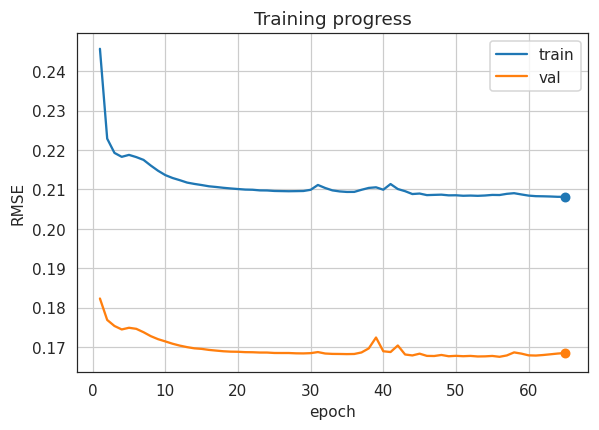

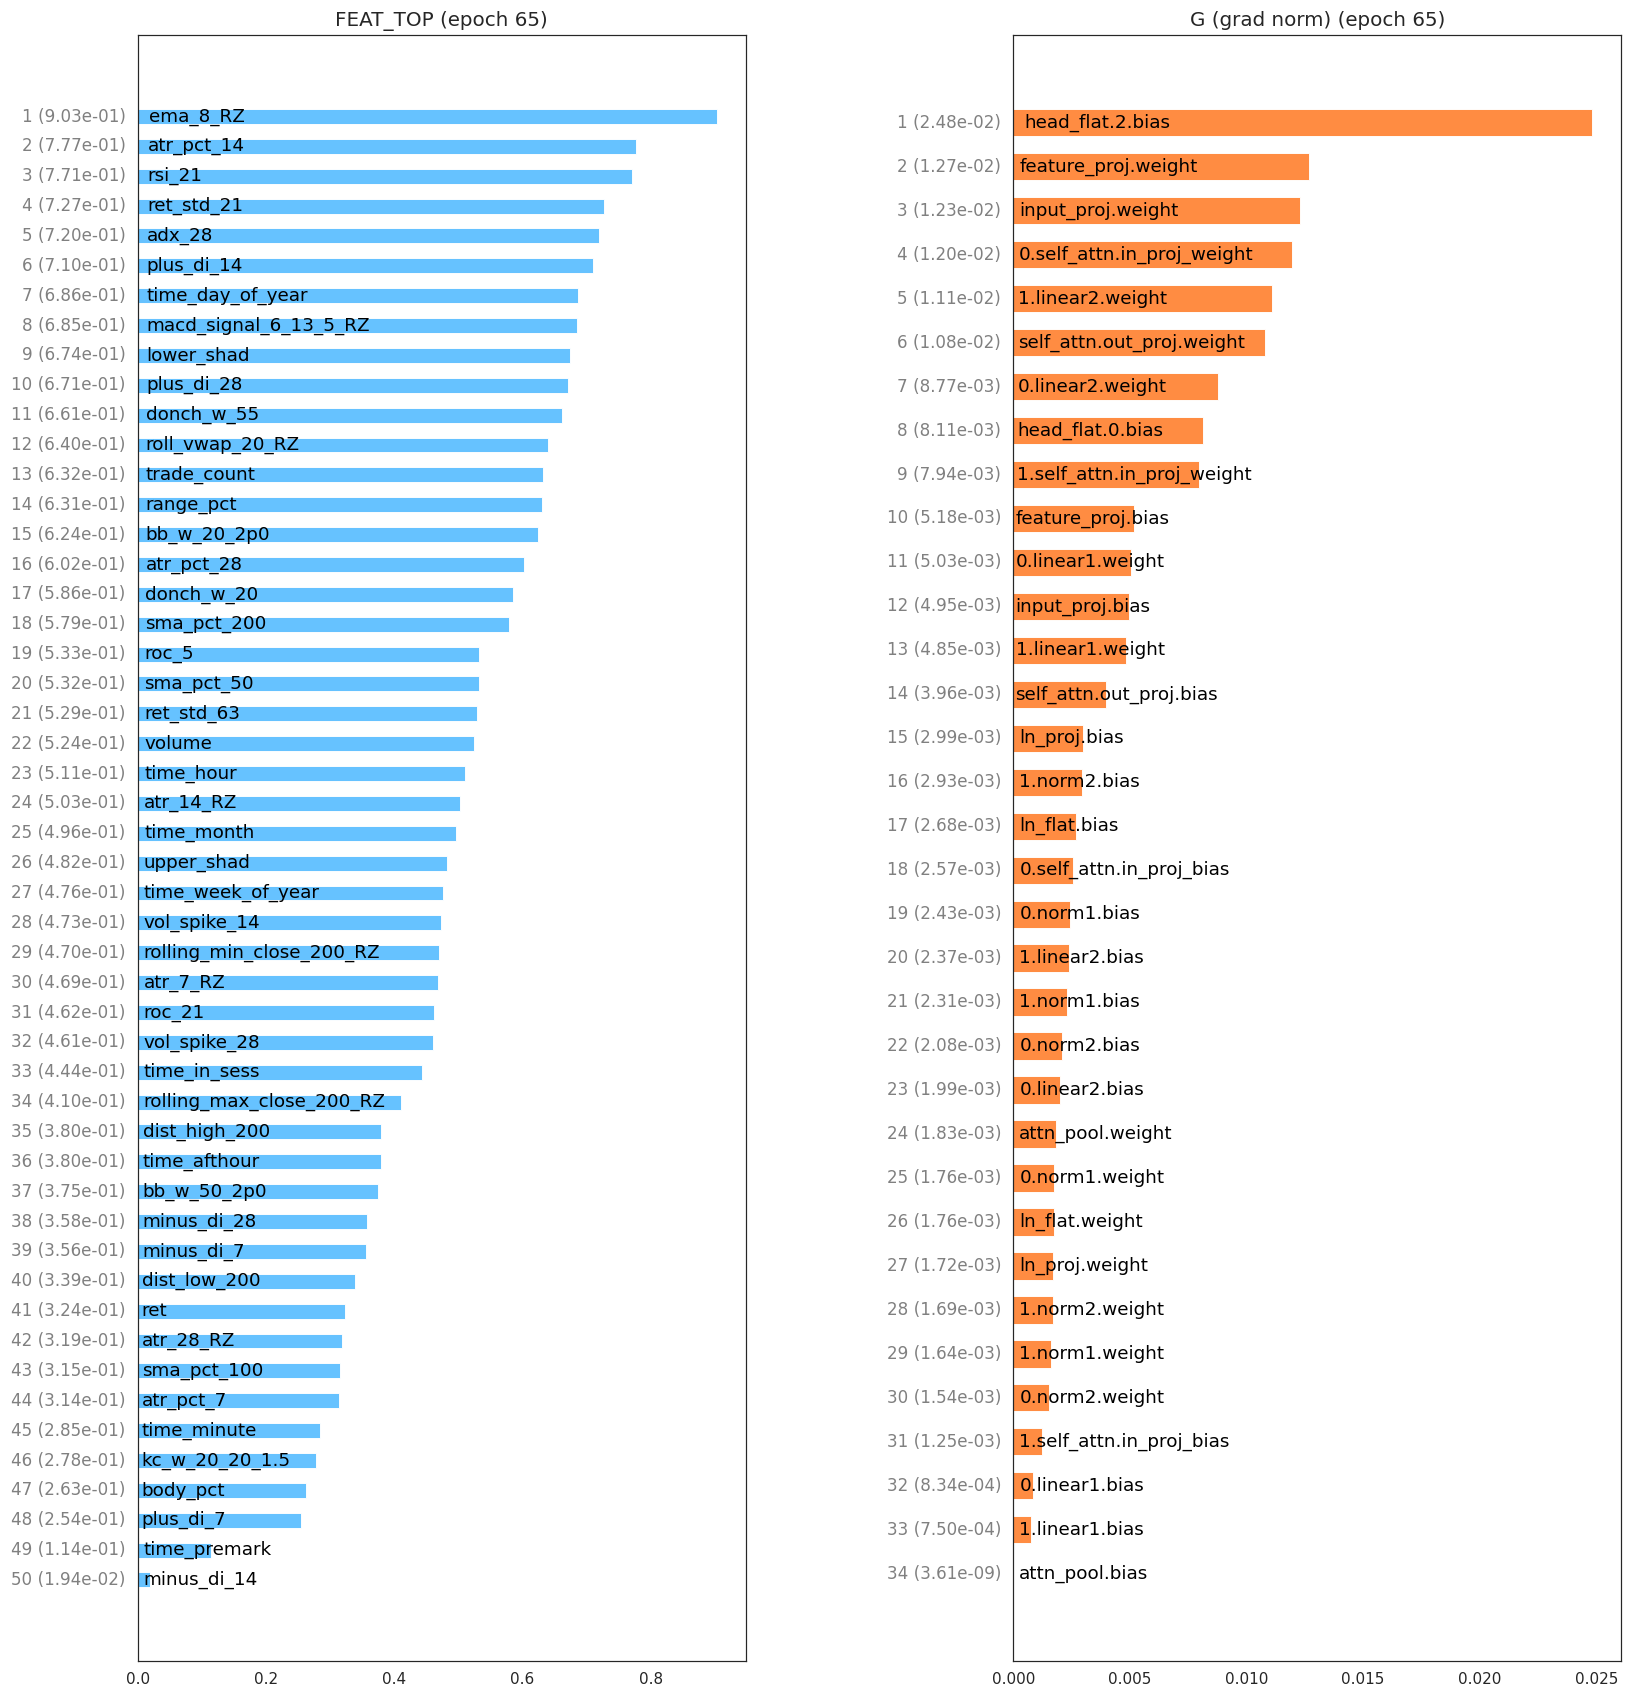

In [8]:
# importlib.reload(models_custom) #############
importlib.reload(params) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader
)